This notebook contains an implementation of the third place result in the Rossman Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Much of our focus has been computer-vision and NLP tasks, which largely deals with unstructured data.

However, most of the data informing KPI's in industry are structured, time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

In [1]:
%matplotlib inline

In [2]:
import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K
import matplotlib.pyplot as plt, xgboost, operator, random, pickle

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
from utils2 import *

In [4]:
np.set_printoptions(threshold=50, edgeitems=20)

In [5]:
limit_mem()

In [15]:
from isoweek import Week
from pandas_summary import DataFrameSummary

In [16]:
#%cd /data/datasets/rossman/
#%cd data/rossmann/
%cd ../data2/rossmann/

/home/ubuntu/courses/data2/rossmann


## Create datasets

In addition to the provided data, we will be using external datasets put together by participants in the Kaggle competition. You can download all of them [here](http://files.fast.ai/part2/lesson14/rossmann.tgz).

For completeness, the implementation used to put them together is included below.

In [12]:
def concat_csvs(dirname):
    os.chdir(dirname)
    filenames=glob.glob("*.csv")

    wrote_header = False
    with open("../"+dirname+".csv","w") as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                     outputfile.write(name + "," + line)
                outputfile.write("\n")

    os.chdir("..")

In [13]:
# concat_csvs('googletrend')
# concat_csvs('weather')

Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to the German state they are in
* List of German state names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather
* test: testing set

In [14]:
table_names = ['train', 'store', 'store_states', 'state_names', 
               'googletrend', 'weather', 'test']

We'll be using the popular data manipulation framework pandas.

Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into a list `tables`.

In [15]:
tables = [pd.read_csv(fname+'.csv', low_memory=False) for fname in table_names]

In [16]:
from IPython.display import HTML, display

We can use `head()` to get a quick look at the contents of each table:
* train: Contains store information on a daily basis, tracks things like sales, customers, whether that day was a holdiay, etc.
* store: general info about the store including competition, etc.
* store_states: maps store to state it is in
* state_names: Maps state abbreviations to names
* googletrend: trend data for particular week/state
* weather: weather conditions for each state
* test: Same as training table, w/o sales and customers


In [17]:
for t in tables: display(t.head())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


This is very representative of a typical industry dataset.

The following returns summarized aggregate information to each table accross each field.

In [18]:
for t in tables: display(DataFrameSummary(t).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


,StateName,State
count,16,16
unique,16,16
top,BadenWuerttemberg,TH
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


## Data Cleaning / Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

In [19]:
train, store, store_states, state_names, googletrend, weather, test = tables

In [20]:
len(train),len(test)

(1017209, 41088)

Turn state Holidays to Bool

In [21]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday = test.StateHoliday!='0'

Define function for joining tables on specific fields.

By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "_y" to those on the right.

In [22]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

Join weather/state names.

In [23]:
weather = join_df(weather, state_names, "file", "StateName")

In pandas you can add new columns to a dataframe by simply defining it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name 'NI' with the usage in the rest of the table, 'HB,NI'. This is a good opportunity to highlight pandas indexing. We can use `.loc[rows, cols]` to select a list of rows and a list of columns from the dataframe. In this case, we're selecting rows w/ statename 'NI' by using a boolean list `googletrend.State=='NI'` and selecting "State".

In [24]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

**You should always consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities.**

In [25]:
def add_datepart(df):
    df.Date = pd.to_datetime(df.Date)
    df["Year"] = df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Week"] = df.Date.dt.week
    df["Day"] = df.Date.dt.day

We'll add to every table w/ a date field.

In [26]:
add_datepart(weather)
add_datepart(googletrend)
add_datepart(train)
add_datepart(test)

In [27]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

Now we can outer join all of our data into a single dataframe.

Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields.

One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

*Aside*: Why not just do an inner join?
If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [28]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [29]:
joined = join_df(train, store, "Store")
len(joined[joined.StoreType.isnull()])

0

In [30]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()])

0

In [31]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()])

0

In [32]:
joined = join_df(joined, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()])

0

In [33]:
joined_test = test.merge(store, how='left', left_on='Store', right_index=True)
len(joined_test[joined_test.StoreType.isnull()])

48

Next we'll fill in missing values to avoid complications w/ na's.

In [34]:
joined.CompetitionOpenSinceYear = joined.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
joined.CompetitionOpenSinceMonth = joined.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
joined.Promo2SinceYear = joined.Promo2SinceYear.fillna(1900).astype(np.int32)
joined.Promo2SinceWeek = joined.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of `apply()` in mapping a function across dataframe values.

In [35]:
joined["CompetitionOpenSince"] = pd.to_datetime(joined.apply(lambda x: datetime.datetime(
    x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth, 15), axis=1).astype(pd.datetime))
joined["CompetitionDaysOpen"] = joined.Date.subtract(joined["CompetitionOpenSince"]).dt.days

We'll replace some erroneous / outlying data.

In [36]:
joined.loc[joined.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
joined.loc[joined.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

Added "CompetitionMonthsOpen" field, limit the maximum to 2 years to limit number of unique embeddings.

In [37]:
joined["CompetitionMonthsOpen"] = joined["CompetitionDaysOpen"]//30
joined.loc[joined.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,
        1, 14, 20,  8, 18,  6, 21,  5], dtype=int64)

Same process for Promo dates.

In [38]:
joined["Promo2Since"] = pd.to_datetime(joined.apply(lambda x: Week(
    x.Promo2SinceYear, x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
joined["Promo2Days"] = joined.Date.subtract(joined["Promo2Since"]).dt.days

In [39]:
joined.loc[joined.Promo2Days<0, "Promo2Days"] = 0
joined.loc[joined.Promo2SinceYear<1990, "Promo2Days"] = 0

In [40]:
joined["Promo2Weeks"] = joined["Promo2Days"]//7
joined.loc[joined.Promo2Weeks<0, "Promo2Weeks"] = 0
joined.loc[joined.Promo2Weeks>25, "Promo2Weeks"] = 25
joined.Promo2Weeks.unique()

array([ 0, 25, 17,  8, 13, 24, 16,  7, 12, 23, 15,  6, 11, 22, 14,  5, 10,
       21,  4,  9, 20,  3, 19,  2, 18,  1], dtype=int64)

## Durations

It is common when working with time series data to extract data that explains relationships across rows as opposed to columns, e.g.:
* Running averages
* Time until next event
* Time since last event

This is often difficult to do with most table manipulation frameworks, since they are designed to work with relationships across columns. As such, we've created a class to handle this type of data.

In [41]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]

We've defined a class `elapsed` for cumulative counting across a sorted dataframe.

Given a particular field `fld` to monitor, this object will start tracking time since the last occurrence of that field. When the field is seen again, the counter is set to zero.

Upon initialization, this will result in datetime na's until the field is encountered. This is reset every time a new store is seen.

We'll see how to use this shortly.

In [42]:
class elapsed(object):
    def __init__(self, fld):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        self.last_store = 0
        
    def get(self, row):
        if row.Store != self.last_store:  # reset when a new store is seen
            self.last = pd.to_datetime(np.nan)
            self.last_store = row.Store
        if (row[self.fld]): self.last = row.Date  # keep this date
        return row.Date-self.last  # return elapsed days

In [43]:
df = train[columns]

And a function for applying said class across dataframe rows and adding values to a new column.

In [44]:
def add_elapsed(fld, prefix):
    sh_el = elapsed(fld)
    df[prefix+fld] = df.apply(sh_el.get, axis=1)

Let's walk through an example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call `add_elapsed('SchoolHoliday', 'After')`:
This will generate an instance of the `elapsed` class for School Holiday:
* Instance applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another promotion.

In [45]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

We'll do this for two more fields.

In [46]:
fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

In [47]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
add_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(fld, 'Before')

We're going to set the active index to Date.

In [48]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [49]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']

In [50]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(pd.Timedelta(0)).dt.days

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [51]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()

In [52]:
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()

In [53]:
bwd.head()

Store  SchoolHoliday  StateHoliday  Promo
Store Date                                                 
1     2013-01-01    1.0            1.0           1.0    0.0
      2013-01-02    2.0            2.0           1.0    0.0
      2013-01-03    3.0            3.0           1.0    0.0
      2013-01-04    4.0            4.0           1.0    0.0
      2013-01-05    5.0            5.0           1.0    0.0

Next we want to drop the Store indices grouped together in the window function.

Often in pandas, there is an option to do this in place. This is time and memory efficient when working with large datasets.

In [54]:
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)

In [55]:
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [56]:
df.reset_index(inplace=True)

Now we'll merge these values onto the df.

In [57]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [58]:
df.drop(columns,1,inplace=True)

In [59]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,55,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0
3,2015-07-28,1,0,0,54,0,0,0,2.0,0.0,2.0,4.0,0.0,4.0
4,2015-07-27,1,0,0,53,0,0,0,1.0,0.0,1.0,5.0,0.0,5.0


It's usually a good idea to back up large tables of extracted / wrangled features before you join them onto another one, that way you can go back to it easily if you need to make changes to it.

In [60]:
df.to_csv('df.csv')

In [61]:
df = pd.read_csv('df.csv', index_col=0)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [62]:
df["Date"] = pd.to_datetime(df.Date)

In [63]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

In [64]:
joined = join_df(joined, df, ['Store', 'Date'])

We'll back this up as well.

In [65]:
joined.to_csv('joined.csv')

We now have our final set of engineered features.

In [66]:
joined = pd.read_csv('joined.csv', index_col=0)
joined["Date"] = pd.to_datetime(joined.Date)
joined.columns

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\arraysetops.py:466: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Week', 'Day',
       'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 'State', 'file',
       'week', 'trend', 'Date_y', 'Month_y', 'Day_y', 'file_DE', 'week_DE',
       'trend_DE', 'Date_DE', 'State_DE', 'Month_DE', 'Day_DE', 'file_y',
       'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
       'Dew_PointC', 'MeanDew_PointC', 'Min_DewpointC', 'Max_Humidity',
       'Mean_Humidity', 'Min_Humidity', 'Max_Sea_Level_PressurehPa',
       'Mean_Sea_Level_PressurehPa', 'Min_Sea_Level_PressurehPa',
       'Max_VisibilityKm', 'Mean_VisibilityKm', 'Min_VisibilitykM',
       'Max_Wind_SpeedKm_h', 'Mean_Wind_SpeedKm_h', 'Max_Gust_SpeedKm_h',
       'Precipitationmm', 'CloudCover', 'Events', 'WindDirDegrees',
       

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

## Create features

Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

In [12]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler

This dictionary maps categories to embedding dimensionality. In generally, categories we might expect to be conceptually more complex have larger dimension.

In [68]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 6, 'Year': 2, 'Month': 6,
'Day': 10, 'StateHoliday': 3, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 2, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_fw': 1,
'StateHoliday_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

Name categorical variables

In [69]:
cat_vars = [o[0] for o in 
            sorted(cat_var_dict.items(), key=operator.itemgetter(1), reverse=True)]

In [70]:
"""cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday',
           'StoreType', 'Assortment', 'Week', 'Events', 'Promo2SinceYear',
            'CompetitionOpenSinceYear', 'PromoInterval', 'Promo', 'SchoolHoliday', 'State']"""

"cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday',\n           'StoreType', 'Assortment', 'Week', 'Events', 'Promo2SinceYear',\n            'CompetitionOpenSinceYear', 'PromoInterval', 'Promo', 'SchoolHoliday', 'State']"

Likewise for continuous

In [71]:
# mean/max wind; min temp; cloud; min/mean humid; 
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [72]:
"""contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 
   'Max_Humidity', 'trend', 'trend_DE', 'AfterStateHoliday', 'BeforeStateHoliday']"""

"contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', \n   'Max_Humidity', 'trend', 'trend_DE', 'AfterStateHoliday', 'BeforeStateHoliday']"

Replace nulls w/ 0 for continuous, "" for categorical.

In [73]:
for v in contin_vars: joined.loc[joined[v].isnull(), v] = 0
for v in cat_vars: joined.loc[joined[v].isnull(), v] = ""

Here we create a list of tuples, each containing a variable and an instance of a transformer for that variable.

For categoricals, we use a label encoder that maps categories to continuous integers. For continuous variables, we standardize them.

In [74]:
cat_maps = [(o, LabelEncoder()) for o in cat_vars]
contin_maps = [([o], StandardScaler()) for o in contin_vars]

The same instances need to be used for the test set as well, so values are mapped/standardized appropriately.

DataFrame mapper will keep track of these variable-instance mappings.

In [75]:
cat_mapper = DataFrameMapper(cat_maps)
cat_map_fit = cat_mapper.fit(joined)
cat_cols = len(cat_map_fit.features)
cat_cols

22

In [76]:
contin_mapper = DataFrameMapper(contin_maps)
contin_map_fit = contin_mapper.fit(joined)
contin_cols = len(contin_map_fit.features)
contin_cols

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


16

Example of first five rows of zeroth column being transformed appropriately.

In [77]:
cat_map_fit.transform(joined)[0,:5], contin_map_fit.transform(joined)[0,:5]

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([ 0, 30,  4,  6,  4], dtype=int64),
 array([-0.53772351,  1.02444552,  0.81863226,  0.32504749,  0.61112004]))

In [362]:
cat_map_fit.transform(joined).shape, contin_map_fit.transform(joined).shape

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


((1017209, 22), (1017209, 16))

We can also pickle these mappings, which is great for portability!

In [78]:
pickle.dump(contin_map_fit, open('contin_maps.pickle', 'wb'))
pickle.dump(cat_map_fit, open('cat_maps.pickle', 'wb'))

For my categorical variables, you can see here the number of unique classes in every one.  

So here's my 1115 stores and 31 days of the month and 7 days of the week and so forth.  So that's the kind of key preprocessing that has to be done.  

In [79]:
[len(o[1].classes_) for o in cat_map_fit.features]

[1115, 31, 7, 12, 12, 23, 8, 22, 2, 3, 4, 3, 25, 4, 52, 26, 6, 6, 3, 3, 8, 8]

## Sample data

Next, the authors removed all instances where the store had zero sale / was closed.

In [80]:
joined_sales = joined[joined.Sales!=0]
n = len(joined_sales)

We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little EDA reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. Be ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

In [81]:
n

844338

We're going to run on a sample.

In [82]:
samp_size = 100000
np.random.seed(42)
idxs = sorted(np.random.choice(n, samp_size, replace=False))

In [83]:
joined_samp = joined_sales.iloc[idxs].set_index("Date")

In [84]:
samp_size = n
joined_samp = joined_sales.set_index("Date")

In time series data, cross-validation is not random. Instead, our holdout data is always the most recent data, as it would be in real application.

We've taken the last 10% as our validation set.

In [85]:
train_ratio = 0.9
train_size = int(samp_size * train_ratio)

In [97]:
train_size

759904

In [87]:
joined_valid = joined_samp[train_size:]
joined_train = joined_samp[:train_size]
len(joined_valid), len(joined_train)

(84434, 759904)

Here's a preprocessor for our categoricals using our instance mapper.

In [88]:
def cat_preproc(dat):
    return cat_map_fit.transform(dat).astype(np.int64)

In [89]:
cat_map_train = cat_preproc(joined_train)
cat_map_valid = cat_preproc(joined_valid)

Same for continuous.

In [90]:
def contin_preproc(dat):
    return contin_map_fit.transform(dat).astype(np.float32)

In [91]:
contin_map_train = contin_preproc(joined_train)
contin_map_valid = contin_preproc(joined_valid)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Grab our targets.

In [92]:
y_train_orig = joined_train.Sales
y_valid_orig = joined_valid.Sales

Finally, the authors modified the target values by applying a logarithmic transformation and normalizing to unit scale by dividing by the maximum log value.

Log transformations are used on this type of data frequently to attain a nicer shape. 

Further by scaling to the unit interval we can now use a sigmoid output in our neural network. Then we can multiply by the maximum log value to get the original log value and transform back.

In [93]:
max_log_y = np.max(np.log(joined_samp.Sales))
y_train = np.log(y_train_orig)/max_log_y
y_valid = np.log(y_valid_orig)/max_log_y

Note: Some testing shows this doesn't make a big difference.

In [273]:
#y_train = np.log(y_train)
ymean=y_train_orig.mean()
ystd=y_train_orig.std()
"""
y_train = (y_train_orig-ymean)/ystd
#y_valid = np.log(y_valid)
y_valid = (y_valid_orig-ymean)/ystd
"""

'\ny_train = (y_train_orig-ymean)/ystd\n#y_valid = np.log(y_valid)\ny_valid = (y_valid_orig-ymean)/ystd\n'

Root-mean-squared percent error is the metric Kaggle used for this competition.

In [94]:
def rmspe(y_pred, targ = y_valid_orig):
    pct_var = (targ - y_pred)/targ
    return math.sqrt(np.square(pct_var).mean())

These undo the target transformations.

In [95]:
def log_max_inv(preds, mx = max_log_y):
    return np.exp(preds * mx)

In [96]:
def normalize_inv(preds):
    return preds * ystd + ymean

## Create models

Now we're ready to put together our models.

Much of the following code has commented out portions / alternate implementations.

In [739]:
"""
1 97s - loss: 0.0104 - val_loss: 0.0083
2 93s - loss: 0.0076 - val_loss: 0.0076
3 90s - loss: 0.0071 - val_loss: 0.0076
4 90s - loss: 0.0068 - val_loss: 0.0075
5 93s - loss: 0.0066 - val_loss: 0.0075
6 95s - loss: 0.0064 - val_loss: 0.0076
7 98s - loss: 0.0063 - val_loss: 0.0077
8 97s - loss: 0.0062 - val_loss: 0.0075
9 95s - loss: 0.0061 - val_loss: 0.0073
0 101s - loss: 0.0061 - val_loss: 0.0074
"""

'\n1 97s - loss: 0.0104 - val_loss: 0.0083\n2 93s - loss: 0.0076 - val_loss: 0.0076\n3 90s - loss: 0.0071 - val_loss: 0.0076\n4 90s - loss: 0.0068 - val_loss: 0.0075\n5 93s - loss: 0.0066 - val_loss: 0.0075\n6 95s - loss: 0.0064 - val_loss: 0.0076\n7 98s - loss: 0.0063 - val_loss: 0.0077\n8 97s - loss: 0.0062 - val_loss: 0.0075\n9 95s - loss: 0.0061 - val_loss: 0.0073\n0 101s - loss: 0.0061 - val_loss: 0.0074\n'

In [267]:
def split_cols(arr): return np.hsplit(arr,arr.shape[1])

In [268]:
map_train = split_cols(cat_map_train) + [contin_map_train]
map_valid = split_cols(cat_map_valid) + [contin_map_valid]

In [269]:
len(map_train)

23

Helper function for getting categorical name and dim.

In [151]:
def cat_map_info(feat): return feat[0], len(feat[1].classes_)

In [156]:
cat_map_info(cat_map_fit.features[1])

('Day', 31)

In [190]:
def my_init(scale):
    #return lambda shape, name=None: initializations.uniform(shape, scale=scale, name=name)
    return lambda shape, name=None: initializers.RandomUniform(shape, minval=-scale, maxval=scale, name=name)

In [255]:
def emb_init(shape, name=None): 
    #return initializations.uniform(shape, scale=2/(shape[1]+1), name=name)
    print('shape[1]:',shape[1])
    scale = 0.15#float(2/(shape[1]+1))
    print('scale:', -scale)
    #return initializers.RandomUniform(shape=shape[1], minval=(-scale), maxval=scale, name=name)
    return initializers.RandomUniform(minval=(-scale), maxval=scale)
    #return initializers.VarianceScaling(shape, scale=scale, distribution="uniform", name=name)

Helper function for constructing embeddings. Notice commented out codes, several different ways to compute embeddings at play.

Also, note we're flattening the embedding. Embeddings in Keras come out as an element of a sequence like we might use in a sequence of words; here we just want to concatenate them so we flatten the 1-vector sequence into a vector.

In [263]:
def get_emb(feat):
    name, c = cat_map_info(feat)
    #c2 = cat_var_dict[name]
    c2 = (c+1)//2
    if c2>50: c2=50
    inp = Input((1,), dtype='int64', name=name+'_in')
    # , W_regularizer=l2(1e-6)
    #u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1, init=emb_init)(inp))
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1)(inp))
    return inp,u

Helper function for continuous inputs.

In [167]:
def get_contin(feat):
    name = feat[0][0]
    inp = Input((1,), name=name+'_in')
    return inp, Dense(1, name=name+'_d', init=my_init(1.))(inp)

Let's build them.

In [168]:
contin_inp = Input((contin_cols,), name='contin')
contin_out = Dense(contin_cols*10, activation='relu', name='contin_d')(contin_inp)
#contin_out = BatchNormalization()(contin_out)

Now we can put them together. Given the inputs, continuous and categorical embeddings, we're going to concatenate all of them.

Next, we're going to pass through some dropout, then two dense layers w/ ReLU activations, then dropout again, then the sigmoid activation we mentioned earlier.

In [264]:
embs = [get_emb(feat) for feat in cat_map_fit.features]
#conts = [get_contin(feat) for feat in contin_map_fit.features]
#contin_d = [d for inp,d in conts]
x = merge([emb for inp,emb in embs] + [contin_out], mode='concat')
#x = merge([emb for inp,emb in embs] + contin_d, mode='concat')

#x = Dropout(0.02)(x)
x = Dense(1000, activation='relu', init='uniform')(x)
x = Dense(500, activation='relu', init='uniform')(x)
#x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model([inp for inp,emb in embs] + [contin_inp], x)
#model = Model([inp for inp,emb in embs] + [inp for inp,d in conts], x)
model.compile('adam', 'mean_absolute_error')
#model.compile(Adam(), 'mse')

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\legacy\layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1000, activation="relu", kernel_initializer="uniform")`
  
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(500, activation="relu", kernel_initializer="uniform")`
  if __name__ == '__main__':


### Start training

In [270]:
%%time 
hist = model.fit(map_train, y_train, batch_size=128, nb_epoch=25,
                 verbose=0, validation_data=(map_valid, y_valid))

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Wall time: 1h 33min 59s


In [271]:
hist.history

{'loss': [0.009771702013691447,
  0.007101570902905325,
  0.006613266332975536,
  0.006316216973058499,
  0.0060920402295755694,
  0.005944035473543321,
  0.005806865100475287,
  0.00571841635284123,
  0.005643781630994778,
  0.0055722654822236645,
  0.005505947635333414,
  0.005454282364456429,
  0.005398479059956497,
  0.005351234456317885,
  0.0053148973479952635,
  0.005278119965524157,
  0.00523749339990903,
  0.00520176277179231,
  0.005177279796237825,
  0.005147504320251848,
  0.005122490919017808,
  0.005098321980733181,
  0.005076480808296792,
  0.0050531533987287595,
  0.005033636047363773],
 'val_loss': [0.010872273717922615,
  0.00996476322422021,
  0.009830314389748736,
  0.009642937103691017,
  0.009656129580767715,
  0.009988885782736706,
  0.010091390165473628,
  0.0099377061964639,
  0.010592053438800599,
  0.010319068716099448,
  0.010432037689206664,
  0.010091823982597026,
  0.010147248257240914,
  0.010502824503487657,
  0.010326694035021748,
  0.01037476927868035

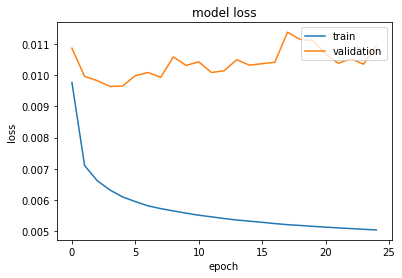

In [272]:
plot_train(hist)

In [275]:
preds = np.squeeze(model.predict(map_valid, 1024))

In [281]:
preds[0:5]

array([0.83839744, 0.8598411 , 0.7963615 , 0.8338557 , 0.8160902 ],
      dtype=float32)

Result on validation data:  0.1678 (samp 150k, 0.75 trn)

In [288]:
log_max_inv(preds[0:5])

array([7450.8706, 9359.364 , 4764.975 , 7099.5415, 5877.3184],
      dtype=float32)

In [293]:
y_valid_orig[:5].values

array([7956, 8958, 4676, 6913, 6157], dtype=int64)

## Using 3rd place data

In [308]:
#pkl_path = '/data/jhoward/github/entity-embedding-rossmann/'
#pkl_path = './data/rossmann/'
pkl_path = ''

In [509]:
pickle.dump([joined_sales, joined_sales.Sales], open('feature_train_data.pickle', 'wb'))

In [531]:
def load_pickle(fname): 
    return pickle.load(open(pkl_path+fname + '.pickle', 'rb'))

In [532]:
[x_pkl_orig, y_pkl_orig] = load_pickle('feature_train_data')

In [533]:
y_pkl = y_pkl_orig

In [549]:
max_log_y_pkl = np.max(np.log(y_pkl_orig))
y_pkl = np.log(y_pkl_orig)/max_log_y_pkl

In [534]:
pkl_vars = cat_vars + contin_vars

In [535]:
cat_map_fit.transform(x_pkl_orig).shape, contin_map_fit.transform(x_pkl_orig).shape

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


((844338, 22), (844338, 16))

In [536]:
x_pkl = np.concatenate([cat_map_fit.transform(x_pkl_orig).astype(np.int64), contin_map_fit.transform(x_pkl_orig).astype(np.float32)], axis=1)

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [537]:
x_pkl.shape, y_pkl.shape

((844338, 38), (844338,))

In [518]:
x_pkl = x_pkl[idxs]
y_pkl = y_pkl[idxs]

In [519]:
x_pkl.shape, y_pkl.shape

((100000, 38), (100000,))

In [538]:
train_size=int(len(x_pkl)*0.9)

In [557]:
x_pkl_trn, x_pkl_val = x_pkl[:train_size], x_pkl[train_size:]
y_pkl_trn, y_pkl_val = y_pkl[:train_size], y_pkl[train_size:]

In [558]:
x_pkl_trn.shape, y_pkl_trn.shape, x_pkl_val.shape, y_pkl_val.shape

((759904, 38), (759904,), (84434, 38), (84434,))

In [559]:
xgb_parms = {'learning_rate': 0.1, 'subsample': 0.6, 
             'colsample_bylevel': 0.6, 'silent': True, 'objective': 'reg:linear'}

In [560]:
xdata_pkl = xgboost.DMatrix(x_pkl_trn, y_pkl_trn, feature_names=pkl_vars)

In [561]:
xdata_val_pkl = xgboost.DMatrix(x_pkl_val, y_pkl_val, feature_names=pkl_vars)

In [562]:
xgb_parms['seed'] = random.randint(0,1e9)
model_pkl = xgboost.train(xgb_parms, xdata_pkl)

In [563]:
model_pkl.eval(xdata_val_pkl)

'[0]\teval-rmse:0.113917'

In [ ]:
#0.117473

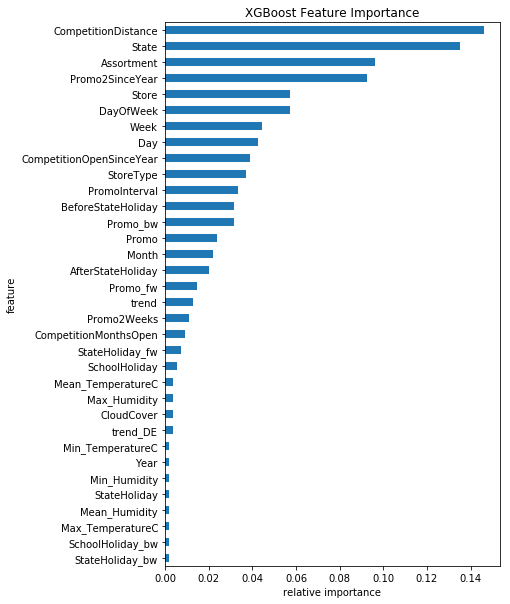

In [564]:
importance = model_pkl.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance');

### Neural net

In [410]:
#np.savez_compressed('vars.npz', pkl_cats, pkl_contins)
#np.savez_compressed('deps.npz', y_pkl)

In [411]:
pkl_cats = np.stack([x_pkl[:,pkl_vars.index(f)] for f in cat_vars], 1)
pkl_contins = np.stack([x_pkl[:,pkl_vars.index(f)] for f in contin_vars], 1)

In [412]:
co_enc = StandardScaler().fit(pkl_contins)
pkl_contins = co_enc.transform(pkl_contins)

In [413]:
pkl_contins_trn, pkl_contins_val = pkl_contins[:train_size], pkl_contins[train_size:]
pkl_cats_trn, pkl_cats_val = pkl_cats[:train_size], pkl_cats[train_size:]
y_pkl_trn, y_pkl_val = y_pkl[:train_size], y_pkl[train_size:]

In [414]:
def get_emb_pkl(feat):
    name, c = cat_map_info(feat)
    c2 = (c+2)//3
    if c2>50: c2=50
    inp = Input((1,), dtype='int64', name=name+'_in')
    u = Flatten(name=name+'_flt')(Embedding(c, c2, input_length=1, init=emb_init)(inp))
    return inp,u

In [415]:
n_pkl_contin = pkl_contins_trn.shape[1]
contin_inp = Input((n_pkl_contin,), name='contin')
contin_out = BatchNormalization()(contin_inp)

In [416]:
map_train_pkl = split_cols(pkl_cats_trn) + [pkl_contins_trn]
map_valid_pkl = split_cols(pkl_cats_val) + [pkl_contins_val]

In [417]:
def train_pkl(bs=128, ne=10):
    return model_pkl.fit(map_train_pkl, y_pkl_trn, batch_size=bs, nb_epoch=ne,
                 verbose=0, validation_data=(map_valid_pkl, y_pkl_val))

In [418]:
def get_model_pkl(): 
    conts = [get_contin_pkl(feat) for feat in contin_map_fit.features]
    embs = [get_emb_pkl(feat) for feat in cat_map_fit.features]
    x = merge([emb for inp,emb in embs] + [contin_out], mode='concat')

    x = Dropout(0.02)(x)
    x = Dense(1000, activation='relu', init='uniform')(x)
    x = Dense(500, activation='relu', init='uniform')(x)
    x = Dense(1, activation='sigmoid')(x)

    model_pkl = Model([inp for inp,emb in embs] + [contin_inp], x)
    model_pkl.compile('adam', 'mean_absolute_error')
    #model.compile(Adam(), 'mse')
    return model_pkl

In [458]:
model_pkl = get_model_pkl()

In [459]:
train_pkl(128, 10).history['val_loss']

[0.0086286964193351811,
 0.0080550193002727963,
 0.0080270905797575273,
 0.00833844816263264,
 0.0078600179936998815,
 0.007661957152165411,
 0.0076301282558615853,
 0.0076333107689942779,
 0.0074799654912108687,
 0.0074509223625492749]

In [460]:
K.set_value(model_pkl.optimizer.lr, 1e-4)
train_pkl(128, 5).history['val_loss']

[0.0074035965020400139,
 0.0073704867357632167,
 0.007380679178817344,
 0.0073204016040114171,
 0.0073323446760613217]

In [739]:
"""
1 97s - loss: 0.0104 - val_loss: 0.0083
2 93s - loss: 0.0076 - val_loss: 0.0076
3 90s - loss: 0.0071 - val_loss: 0.0076
4 90s - loss: 0.0068 - val_loss: 0.0075
5 93s - loss: 0.0066 - val_loss: 0.0075
6 95s - loss: 0.0064 - val_loss: 0.0076
7 98s - loss: 0.0063 - val_loss: 0.0077
8 97s - loss: 0.0062 - val_loss: 0.0075
9 95s - loss: 0.0061 - val_loss: 0.0073
0 101s - loss: 0.0061 - val_loss: 0.0074
"""

'\n1 97s - loss: 0.0104 - val_loss: 0.0083\n2 93s - loss: 0.0076 - val_loss: 0.0076\n3 90s - loss: 0.0071 - val_loss: 0.0076\n4 90s - loss: 0.0068 - val_loss: 0.0075\n5 93s - loss: 0.0066 - val_loss: 0.0075\n6 95s - loss: 0.0064 - val_loss: 0.0076\n7 98s - loss: 0.0063 - val_loss: 0.0077\n8 97s - loss: 0.0062 - val_loss: 0.0075\n9 95s - loss: 0.0061 - val_loss: 0.0073\n0 101s - loss: 0.0061 - val_loss: 0.0074\n'

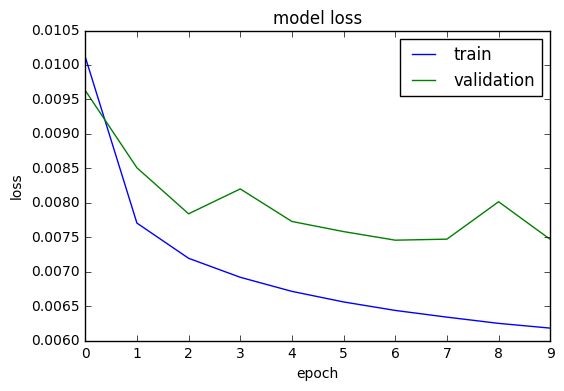

In [116]:
plot_train(hist)

In [1214]:
preds = np.squeeze(model_pkl.predict(map_valid_pkl, 1024))

In [1222]:
y_orig_pkl_val = log_max_inv(y_pkl_val, max_log_y_pkl)

In [1224]:
rmspe(log_max_inv(preds, max_log_y_pkl), y_orig_pkl_val)

0.11084739924546773

## XGBoost

Xgboost is extremely quick and easy to use. Aside from being a powerful predictive model, it gives us information about feature importance.

In [423]:
X_train = np.concatenate([cat_map_train, contin_map_train], axis=1)

In [424]:
X_valid = np.concatenate([cat_map_valid, contin_map_valid], axis=1)

In [425]:
all_vars = cat_vars + contin_vars

In [426]:
xgb_parms = {'learning_rate': 0.1, 'subsample': 0.6, 
             'colsample_bylevel': 0.6, 'silent': True, 'objective': 'reg:linear'}

In [427]:
xdata = xgboost.DMatrix(X_train, y_train, feature_names=all_vars)

In [428]:
xdata_val = xgboost.DMatrix(X_valid, y_valid, feature_names=all_vars)

In [432]:
xgb_parms['seed'] = random.randint(0,1e9)
model = xgboost.train(xgb_parms, xdata)

In [433]:
model.eval(xdata_val)

'[0]\teval-rmse:0.113889'

In [434]:
model.eval(xdata_val)

'[0]\teval-rmse:0.113889'

Easily, competition distance is the most important, while events are not important at all.

In real applications, putting together a feature importance plot is often a first step. Oftentimes, we can remove hundreds of thousands of features from consideration with importance plots. 

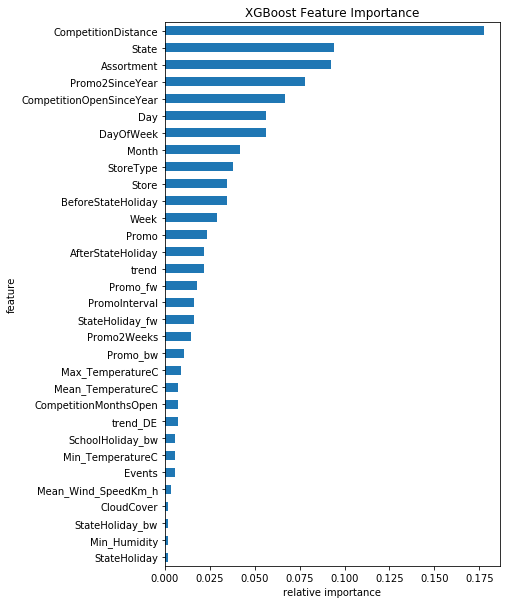

In [547]:
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance');

## End